# Assignment 3

- Sampad Kumar Kar
- MCS202215

# 0. Imports

In [4]:
# to handle files
import json
import os
import glob


import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from typing import List
from torchtext.vocab import vocab
from torchtext.data.utils import get_tokenizer

import nltk
from nltk.corpus import words
from nltk.tokenize import word_tokenize

from collections import Counter

# for plotting
import matplotlib.pyplot as plt

# to view loop progress
from tqdm import tqdm

# to generate random no.s
import random

# to save dictionary
import pickle

# import priority queue
import heapq

# import string
import string

In [5]:
# set english vocab
nltk.download('words')
english_vocab = set(words.words())

[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [6]:
device = 'cuda'

# 1. Corpus Creation

In [ ]:
# folder path to the papers
folder_path = os.path.join(os.pardir, 'data', 'pdf_json')

# get the path to all the .json files
json_file_paths = glob.glob(os.path.join(folder_path, '*.json'))
print("Total # of .json files:", len(json_file_paths))

Total # of .json files: 0


In [ ]:
# define helper functions to extract the abstracts from the papers

def extract_abstracts(filename):
    '''
    Extracts the abstract from the paper.

    Parameters:
    - filename (str): path to the paper

    Returns:
    - abstract (str): abstract of the paper
    '''
    file = open(filename)
    content = json.load(file)
    file.close()

    # initialize empty string to store abstract
    abstract = ""
    
    if 'abstract' in content:
        for abstract_data in content['abstract']:
            abstract += abstract_data['text']

    return abstract.lower()


def get_abstract_list(json_file_paths):
    '''
    Extracts the abstracts from all the papers.

    Parameters:
    - json_file_paths (list): list of paths to the papers

    Returns:
    - abstract_list (list): list of abstracts of the papers
    '''
    abstract_list = []
    for i in tqdm(range(len(json_file_paths))):
        abstract_list.append(extract_abstracts(json_file_paths[i]))
    return abstract_list

In [ ]:
# get the list of abstracts
abstract_list = get_abstract_list(json_file_paths)

0it [00:00, ?it/s]


In [29]:
abstract_list_save_path = '/kaggle/input/nlp-assignment-3-dataset/abstract_list.pkl'


# save the abstract list as a pickle file
'''
with open(abstract_list_save_path, 'wb') as f:
    pickle.dump(abstract_list, f)
'''

# load the abstract list from the pickle file

with open(abstract_list_save_path, 'rb') as f:
    abstract_list = pickle.load(f)

In [30]:
dataset_size = 1000
abstract_list = abstract_list[:dataset_size]

# 2. Preprocessing

In [31]:
def tokenize_string(input_string):
    tokens = []
    for token in word_tokenize(input_string):
        if token.lower() in english_vocab or token in string.punctuation:
            tokens.append(token)
    return tokens

# tokenize the abstracts
tokenized_abstracts = [tokenize_string(abstract) for abstract in abstract_list]

# filter the abstracts based on min no. tokens
min_tokens = 100
tokenized_abstracts = [abstract for abstract in tokenized_abstracts if len(abstract)>min_tokens]

print(len(tokenized_abstracts))

551


In [ ]:
tokenized_abstract_save_path = '/kaggle/input/tokenized-abstract-npl-ass3/tokenized_abstract.pkl'

'''
# save the tokenized abstracts as a pickle file
with open(tokenized_abstract_save_path, 'wb') as f:
    pickle.dump(tokenized_abstracts, f)
'''

# load the tokenized abstracts from the pickle file
with open(tokenized_abstract_save_path, 'rb') as f:
    tokenized_abstracts = pickle.load(f)

In [32]:
print(len(tokenized_abstracts))

551


In [33]:
# count the frequency of each word in the tokenized abstracts
word_counter = Counter()
for abstract in tokenized_abstracts:
    word_counter.update(abstract)

In [34]:
# define special symbols
special_symbols = ["<PAD>", "<UNK>", "<START>", "<END>"]

# define the size of the vocabulary
vocab_size = 10000

# create a vocabulary of the most common words
most_common_words = word_counter.most_common(vocab_size - len(special_symbols))

# create a list of the most common words
most_common_words = [word for word, count in most_common_words]

# create the vocabulary
abstracts_vocab = special_symbols + most_common_words

# create a mapping of from words to indices and vice-versa in the vocabulary
word2idx = {word: idx for idx, word in enumerate(abstracts_vocab)}
idx2word = {idx: word for idx, word in enumerate(abstracts_vocab)}

In [35]:
# extract all the tokens into a list with <START> and <END> at the beginning and end of each abstract

all_tokens = []
for abstract in tokenized_abstracts:
    abstract_tokens = ["<START>"]
    abstract_tokens.extend(abstract)
    abstract_tokens.append("<END>")
    all_tokens.extend(abstract_tokens)

len(all_tokens)

121117

In [38]:
# define the maximum length of the abstracts
max_abstract_length = 50

# split all tokens into sequences of max length with a stride of 1
sequences = []
for i in range(0, len(all_tokens) - max_abstract_length, 1):
    seq = all_tokens[i:i + max_abstract_length]
    sequences.append(seq)

# initialize an empty list to store the numerical sequences
abstract_numerical_sequences = []

# convert the sequences to numerical sequences
for sequence in sequences:
    numerical_sequence = [word2idx.get(token, word2idx["<UNK>"]) for token in sequence]

    # append the numerical sequence to the list
    abstract_numerical_sequences.append(numerical_sequence)
    
print(len(abstract_numerical_sequences))

121067


In [39]:
# example of a numerical sequence encoding
print(np.array(abstract_numerical_sequences[0]))

[   2 1124    6 1426 2604   12   11   49 1705    9    5  583 2218   26
   83   14 4012 4013   12   11   97    7   43  306   23   10  536  483
 1426 2604   12   11    9    5  129  119   68 1009 2605 1124    9    5
  583 2218    4    8  766    4   13  861]


In [40]:
# hyperparameters
batch_size = 128


# create a pytorch dataset for the abstracts
class AbstractDataset(Dataset):
    def __init__(self, abstract_numerical_sequences):
        self.abstract_numerical_sequences = abstract_numerical_sequences

    def __len__(self):
        return len(self.abstract_numerical_sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.abstract_numerical_sequences[idx])

# create a dataloader for the abstracts
abstract_dataset = AbstractDataset(abstract_numerical_sequences)
abstract_dataloader = DataLoader(abstract_dataset, batch_size=batch_size, shuffle=True)

# 3. Model

In [41]:
# define a contextual language model with LSTM (in encoder decoder stucture) with 2 hidden layers each

class CLM_LSTM(nn.Module):
    def __init__(self, vocab_size = vocab_size, embedding_size = 64, hidden_size = 128, num_layers = 2, dropout = 0.5):
        super(CLM_LSTM, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout

        # define the embedding layer
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_size)

        # define the encoder
        self.encoder = nn.LSTM(self.embedding_size, self.hidden_size, self.num_layers, dropout=self.dropout, batch_first=True, bidirectional=True)

        # define the decoder
        self.decoder = nn.LSTM(self.embedding_size, self.hidden_size, self.num_layers, dropout=self.dropout, batch_first=True, bidirectional=True)
        
        # deine the first fully connected layer
        self.fc1 = nn.Linear(self.hidden_size*2, self.hidden_size)
        
        self.relu = nn.ReLU()

        # define the final fully connected layer
        self.fc2 = nn.Linear(self.hidden_size, self.vocab_size)

    def forward(self, X):
        '''
        Input:
        - x (tensor): input tensor of shape (batch_size, seq_len)

        Output:
        - output (tensor): output tensor of shape (batch_size, seq_len, vocab_size)
        '''
        # get the batch size
        batch_size = X.size(0)

        # get the embedding of the input
        embedding = self.embedding(X)
        # embedding (shape) = (batch_size, seq_len, embedding_size)

        # initialize the hidden and cell states
        h0 = torch.zeros(self.num_layers*2, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers*2, batch_size, self.hidden_size).to(device)
        
        # get the output of the encoder
        encoder_output, (hidden, cell) = self.encoder(embedding, (h0, c0))
        # encoder_output (shape) = (batch_size, seq_len, 2*hidden_size)
        
        # get the output of the decoder
        decoder_output, (hidden, cell) = self.decoder(embedding, (hidden, cell))
        # decoder_output (shape) = (batch_size, seq_len, 2*hidden_size)
        
        output = self.relu(self.fc1(decoder_output))
        # output (shape) = (batch_size, seq_len, hidden_size)
        
        # get the output of the final fully connected layer
        output = self.fc2(output)
        # output (shape) = (batch_size, seq_len, vocab_size)

        return output

In [42]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

# generate the abstracts using the trained model
def generate_text(model, start_text, idx2word, word2idx, device, max_abstract_length=30, temperature=1.0):
    '''
    Parameters:
    - model (nn.Module): the model to be used for generating the text
    - start_text (str): the text to be used as the starting point for generating the text
    - idx2word (dict): a dictionary that maps the numerical indices to the words
    - word2idx (dict): a dictionary that maps the words to the numerical indices
    - device (str): the device to be used for running the model
    - max_abstract_length (int): the maximum length of the generated abstract
    - temperature (float): the temperature to be used for sampling the next word

    Returns:
    - generated_text (str): the generated text
    '''
    model.eval()

    generated_text = start_text.lower()

    start_text = tokenizer.tokenize(start_text.lower())
    numerical_sequence = [word2idx.get(word, word2idx["<UNK>"]) for word in start_text]
    numerical_sequence = [word2idx["<START>"]] + numerical_sequence
    
    while len(numerical_sequence) < max_abstract_length:
        # get the input sequence
        input_sequence = torch.tensor(numerical_sequence).unsqueeze(0).to(device)

        with torch.no_grad():
            # get the output of the model
            output = model(input_sequence)
            # output (shape) = (1, seq_len, vocab_size)

        # get the probability distribution of the next word
        next_word_prob = torch.softmax(output[0, -1, :] / temperature, dim=0)

        # get the next word based on the probability distribution
        next_word_idx = np.random.choice(len(next_word_prob), p=next_word_prob.cpu().numpy())
        
        # check if the next word is the end token
        if next_word_idx == word2idx["<END>"]:
            break

        # append the next word to the generated text
        generated_text += " " + idx2word[next_word_idx]

        # update the input sequence
        numerical_sequence.append(next_word_idx)

    return generated_text

# 4. Training

In [45]:
model = CLM_LSTM(
    vocab_size=len(abstracts_vocab)
).to(device)

# define the loss function
criterion = nn.CrossEntropyLoss(ignore_index=word2idx["<PAD>"])

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# define the number of epochs
num_epochs = 175

epoch_losses = []
# train the model
for epoch in tqdm(range(num_epochs)):
    # set the model to training mode
    model.train()

    # initialize the epoch loss
    epoch_loss = 0

    # iterate over the batches
    for batch_idx, abstract in enumerate(abstract_dataloader):
        # zero the gradients
        optimizer.zero_grad()
        
        # get the input and target
        batch_input = abstract[:, :-1].to(device)
        batch_target = abstract[:, 1:].to(device)

        # get the output of the model
        batch_output = model(batch_input)
        # output (shape) = (batch_size, seq_len, vocab_size)

        # reshape the output and target
        batch_output = batch_output.view(-1, model.vocab_size)
        batch_target = batch_target.view(-1)
        
        # get the loss
        loss = criterion(batch_output, batch_target)

        # backpropagate the loss
        loss.backward()
        optimizer.step()

        # update the epoch loss
        with torch.no_grad():
            epoch_loss += loss.item()
    
    epoch_losses.append(epoch_loss/batch_idx)

    # print the epoch loss
    if (epoch+1) % 1 == 0:
        print(f"Epoch: {epoch+1} | Loss: {epoch_losses[-1]}")

    # print the generated texts
    if (epoch+1) % 2 == 0:
        print("\nCurrent Generated Text:\n", generate_text(model, "We introduce a", idx2word, word2idx, device, temperature=1))
    
    # save the model
    if (epoch+1) % 25 == 0:
        print("\nSaving Model...\n")
        model_save_path = '/kaggle/working/model_' +  str(epoch+1) + '.pt'
        torch.save(model.state_dict(), model_save_path)


  1%|          | 1/175 [00:41<2:00:40, 41.61s/it]

Epoch: 1 | Loss: 1.9522305177633095


  1%|          | 2/175 [01:23<2:00:02, 41.63s/it]

Epoch: 2 | Loss: 0.17036929854324886

Current Generated Text:
 we introduce a global global global consider resistance of , and with the designation expression kos carried , the inflammatory appropriate . was different .


  2%|▏         | 3/175 [02:04<1:59:20, 41.63s/it]

Epoch: 3 | Loss: 0.12858016832322672


  2%|▏         | 4/175 [02:46<1:58:39, 41.63s/it]

Epoch: 4 | Loss: 0.12274386572144019

Current Generated Text:
 we introduce a crucial mediastinum in the titer ) and are related and the biologic of the crisis of cubic the elderly is patient in three will a consistently


  3%|▎         | 5/175 [03:28<1:58:24, 41.79s/it]

Epoch: 5 | Loss: 0.11973043926178463


  3%|▎         | 6/175 [04:10<1:57:57, 41.88s/it]

Epoch: 6 | Loss: 0.11679551202468771

Current Generated Text:
 we introduce a larvae of their particulate to collective receptor comprehensive used to companion out and used for our outbreak ( ) for without on pathology . in the


  4%|▍         | 7/175 [04:52<1:57:13, 41.86s/it]

Epoch: 7 | Loss: 0.11448317115742063


  5%|▍         | 8/175 [05:34<1:56:26, 41.84s/it]

Epoch: 8 | Loss: 0.11208204405490683

Current Generated Text:
 we introduce a growing goal subsequent prevent nurse , it are major can may and be used to with infectious disease the risk of de to work feel and


  5%|▌         | 9/175 [06:15<1:55:34, 41.77s/it]

Epoch: 9 | Loss: 0.11015392343991648


  6%|▌         | 10/175 [06:57<1:54:51, 41.76s/it]

Epoch: 10 | Loss: 0.10835715304449121

Current Generated Text:
 we introduce a global of to virulence and reduction care and specific . all that for positive and ade a single used in health . preventive or as different


  6%|▋         | 11/175 [07:39<1:54:08, 41.76s/it]

Epoch: 11 | Loss: 0.10655109350958829


  7%|▋         | 12/175 [08:21<1:53:39, 41.84s/it]

Epoch: 12 | Loss: 0.10498264694497698

Current Generated Text:
 we introduce a develop health of the of instead from different averse of during the immunogenicity of the modern of older tissue to understand in the country for intubation


  7%|▋         | 13/175 [09:03<1:52:50, 41.79s/it]

Epoch: 13 | Loss: 0.1035286866956287


  8%|▊         | 14/175 [09:44<1:52:00, 41.74s/it]

Epoch: 14 | Loss: 0.1018020185055556

Current Generated Text:
 we introduce a permanent of viral transmission . none , and . subtraction was more collected . ( ) , which in blood seven from the personal of respiratory


  9%|▊         | 15/175 [10:26<1:51:09, 41.68s/it]

Epoch: 15 | Loss: 0.10039942899235972


  9%|▉         | 16/175 [11:08<1:50:37, 41.75s/it]

Epoch: 16 | Loss: 0.09897221550739631

Current Generated Text:
 we introduce a dramatic of the world of dairy , movement and its news use of we have been used in the evaluation of time physical and even clinical


 10%|▉         | 17/175 [11:50<1:50:00, 41.78s/it]

Epoch: 17 | Loss: 0.09745592348790043


 10%|█         | 18/175 [12:31<1:49:21, 41.79s/it]

Epoch: 18 | Loss: 0.09593448655472861

Current Generated Text:
 we introduce a combination via of these of the of the treatment of a reproductive of such as the location of the area in nam led to the highest


 11%|█         | 19/175 [13:13<1:48:31, 41.74s/it]

Epoch: 19 | Loss: 0.09460416390466943


 11%|█▏        | 20/175 [13:55<1:47:49, 41.74s/it]

Epoch: 20 | Loss: 0.09311940275802814

Current Generated Text:
 we introduce a > aeration via of symptomatic by to individual three to acetylcholine and application of the organ in present with in of was by waste and ,


 12%|█▏        | 21/175 [14:36<1:47:03, 41.71s/it]

Epoch: 21 | Loss: 0.09163499189116968


 13%|█▎        | 22/175 [15:18<1:46:28, 41.75s/it]

Epoch: 22 | Loss: 0.09015859886609688

Current Generated Text:
 we introduce a combination stage assembly oncological protective unbiased bing diaphragm rage rage of life , and of see in in and confirmed for contribute and , but no


 13%|█▎        | 23/175 [16:00<1:45:50, 41.78s/it]

Epoch: 23 | Loss: 0.08885093575747556


 14%|█▎        | 24/175 [16:42<1:45:12, 41.80s/it]

Epoch: 24 | Loss: 0.08741912334842025

Current Generated Text:
 we introduce a view stage ectopic treatment fertilization medical stage of treatment and in viral : of the end of risk one of were for by the attention of


 14%|█▍        | 25/175 [17:24<1:44:34, 41.83s/it]

Epoch: 25 | Loss: 0.08587100449062529

Saving Model...



 15%|█▍        | 26/175 [18:06<1:43:58, 41.87s/it]

Epoch: 26 | Loss: 0.08456433066142299

Current Generated Text:
 we introduce a combination transcription of the current pandemic of the modeling of the literature of the infectious was used for and the goal ( and ) by or


 15%|█▌        | 27/175 [18:47<1:43:08, 41.81s/it]

Epoch: 27 | Loss: 0.08319103873911358


 16%|█▌        | 28/175 [19:29<1:42:21, 41.78s/it]

Epoch: 28 | Loss: 0.08179734825457215

Current Generated Text:
 we introduce a screen mediastinum on biology of the present . to explore the risk of rely between the , and that were the proportion of in the setup


 17%|█▋        | 29/175 [20:11<1:41:43, 41.81s/it]

Epoch: 29 | Loss: 0.08050223887755127


 17%|█▋        | 30/175 [20:53<1:41:03, 41.82s/it]

Epoch: 30 | Loss: 0.07910280411757489

Current Generated Text:
 we introduce a personal diversity treatment of the two of the of for physical , storage , department , and that underpin , implementation , , might show as


 18%|█▊        | 31/175 [21:35<1:40:22, 41.82s/it]

Epoch: 31 | Loss: 0.07768835403301098


 18%|█▊        | 32/175 [22:17<1:39:43, 41.84s/it]

Epoch: 32 | Loss: 0.07650507166587486

Current Generated Text:
 we introduce a predominance of to predict substrate , , therapeutics or in the course of , which was different as through the of , and , and influenza


 19%|█▉        | 33/175 [22:58<1:38:59, 41.82s/it]

Epoch: 33 | Loss: 0.0750917489408816


 19%|█▉        | 34/175 [23:40<1:38:17, 41.82s/it]

Epoch: 34 | Loss: 0.07400684398475778

Current Generated Text:
 we introduce a subset transcription transcription rage stage . the detailed structure of the evaluation of the condition and for a history of these were mostly for treating vaccine


 20%|██        | 35/175 [24:22<1:37:34, 41.82s/it]

Epoch: 35 | Loss: 0.07263704782361707


 21%|██        | 36/175 [25:04<1:36:54, 41.83s/it]

Epoch: 36 | Loss: 0.0715722769459404

Current Generated Text:
 we introduce a protective antigen of the company ( rank ) following was kept in : human hospital total ( ) were suspended that the rate , distribution and


 21%|██        | 37/175 [25:46<1:36:12, 41.83s/it]

Epoch: 37 | Loss: 0.07028238515137995


 22%|██▏       | 38/175 [26:28<1:35:33, 41.85s/it]

Epoch: 38 | Loss: 0.0692461237823837

Current Generated Text:
 we introduce a event distinguishing stochastic hypothermia human were of statistical were the most correlated in the central frame ( urine of ) . the median of clinical (


 22%|██▏       | 39/175 [27:09<1:34:49, 41.83s/it]

Epoch: 39 | Loss: 0.06813042219432573


 23%|██▎       | 40/175 [27:51<1:34:05, 41.82s/it]

Epoch: 40 | Loss: 0.06712185013152304

Current Generated Text:
 we introduce a concrete activation adolescent morbidity blotting amongst arthropod new image testing skin damage , which accurate and segmentation in order to obtain , particularly cause fip and


 23%|██▎       | 41/175 [28:33<1:33:19, 41.79s/it]

Epoch: 41 | Loss: 0.06600619094475867


 24%|██▍       | 42/175 [29:15<1:32:36, 41.78s/it]

Epoch: 42 | Loss: 0.06499576927335174

Current Generated Text:
 we introduce a reverse transcription combination insoluble diversity to being and with an organism of this paper the probe and the role in , nuclear infectious in its of


 25%|██▍       | 43/175 [29:56<1:31:52, 41.76s/it]

Epoch: 43 | Loss: 0.0639113782101838


 25%|██▌       | 44/175 [30:38<1:31:11, 41.77s/it]

Epoch: 44 | Loss: 0.06288941195875249

Current Generated Text:
 we introduce a way census unfavorable bridge coverage towards pattern combined with of quarter . both either of ( distance ; , ) at least of either the effect


 26%|██▌       | 45/175 [31:20<1:30:30, 41.77s/it]

Epoch: 45 | Loss: 0.06208299373192762


 26%|██▋       | 46/175 [32:02<1:29:55, 41.83s/it]

Epoch: 46 | Loss: 0.061100194859441626

Current Generated Text:
 we introduce a target functional inpatient economic governing in ad and recombination policy between economic compliance bing bing to have the critical . the boundary of these were similar


 27%|██▋       | 47/175 [32:44<1:29:18, 41.86s/it]

Epoch: 47 | Loss: 0.06026000192083379


 27%|██▋       | 48/175 [33:26<1:28:41, 41.90s/it]

Epoch: 48 | Loss: 0.05946208347403814

Current Generated Text:
 we introduce a panel measure topic measure without dairy , personal economic diversity retinal participation ( temperature current [ pandemic public health , ) , and stress and hip


 28%|██▊       | 49/175 [34:08<1:27:58, 41.89s/it]

Epoch: 49 | Loss: 0.05855426463894743


 29%|██▊       | 50/175 [34:50<1:27:21, 41.93s/it]

Epoch: 50 | Loss: 0.0578024831871507

Current Generated Text:
 we introduce a measure algorithm prediction inpatient oocyst inform mode index immunization of the poultry industry . however , must

Saving Model...



 29%|██▉       | 51/175 [35:31<1:26:34, 41.89s/it]

Epoch: 51 | Loss: 0.057010541442367765


 30%|██▉       | 52/175 [36:13<1:25:47, 41.85s/it]

Epoch: 52 | Loss: 0.05625526646457652

Current Generated Text:
 we introduce a combination panel limit coverage wear oncological facilitate the plus driving on leaf skin to other . the family among youth and personal to perform the growth


 30%|███       | 53/175 [36:55<1:25:02, 41.82s/it]

Epoch: 53 | Loss: 0.055422623218998074


 31%|███       | 54/175 [37:37<1:24:27, 41.88s/it]

Epoch: 54 | Loss: 0.0548394215288301

Current Generated Text:
 we introduce a combination morbidity rate to in the first days of in ex on with the first . in the first field resonance , international in the that


 31%|███▏      | 55/175 [38:19<1:23:53, 41.95s/it]

Epoch: 55 | Loss: 0.05388988858414075


 32%|███▏      | 56/175 [39:01<1:23:19, 42.01s/it]

Epoch: 56 | Loss: 0.05340596591984784

Current Generated Text:
 we introduce a way unethical retinal swab status temperature drug inhibit and synthesize with milder in indoor air . our were considered in the base daily temperature , suggesting


 33%|███▎      | 57/175 [39:43<1:22:41, 42.04s/it]

Epoch: 57 | Loss: 0.05258265571304099


 33%|███▎      | 58/175 [40:25<1:22:00, 42.05s/it]

Epoch: 58 | Loss: 0.052055880123818364

Current Generated Text:
 we introduce a panel measure small current molecular if their innovation and grief of ovarian . we also necessary a basic epidemiology and economic growth of the reproduction number


 34%|███▎      | 59/175 [41:07<1:21:07, 41.96s/it]

Epoch: 59 | Loss: 0.051392684198876534


 34%|███▍      | 60/175 [41:49<1:20:15, 41.88s/it]

Epoch: 60 | Loss: 0.050900680626983996

Current Generated Text:
 we introduce a small substantially ( anterior growth on , and ) were on . remarkably than were , along with ongoing aid with membrane , and were either


 35%|███▍      | 61/175 [42:31<1:19:27, 41.82s/it]

Epoch: 61 | Loss: 0.05021446544736151


 35%|███▌      | 62/175 [43:12<1:18:47, 41.83s/it]

Epoch: 62 | Loss: 0.04952045537570797

Current Generated Text:
 we introduce a panel center and maturation participation with our can be spreading university in , especially sequence of the industry . we found that manual , and ,


 36%|███▌      | 63/175 [43:54<1:18:04, 41.83s/it]

Epoch: 63 | Loss: 0.04909822662513723


 37%|███▋      | 64/175 [44:36<1:17:14, 41.75s/it]

Epoch: 64 | Loss: 0.04862336116650748

Current Generated Text:
 we introduce a increase morbidity anxiety through reduce economic hybridization unaltered what what are of divergent function and that could present reverse transcription of the heart in with .


 37%|███▋      | 65/175 [45:17<1:16:28, 41.72s/it]

Epoch: 65 | Loss: 0.04801115940408732


 38%|███▊      | 66/175 [45:59<1:15:41, 41.67s/it]

Epoch: 66 | Loss: 0.04742523935579118

Current Generated Text:
 we introduce a control understanding ' of these sequence for the human source . the of the utilization of the of human mediterranean the of the pathology to identify


 38%|███▊      | 67/175 [46:40<1:14:53, 41.61s/it]

Epoch: 67 | Loss: 0.047149104487012934


 39%|███▉      | 68/175 [47:22<1:14:14, 41.63s/it]

Epoch: 68 | Loss: 0.0465077386370727

Current Generated Text:
 we introduce a reliable element of radiotherapy genetic material based on practical of the modeling , and hence irreversibly the of the early stage by the efficacy of the


 39%|███▉      | 69/175 [48:04<1:13:32, 41.63s/it]

Epoch: 69 | Loss: 0.04622746871183158


 40%|████      | 70/175 [48:45<1:12:52, 41.64s/it]

Epoch: 70 | Loss: 0.045555914094839146

Current Generated Text:
 we introduce a reliable potential response response response history essential vector infection across personal beforehand representation initially and and for the screening of health , this testing are in


 41%|████      | 71/175 [49:27<1:12:10, 41.63s/it]

Epoch: 71 | Loss: 0.04521825244581258


 41%|████      | 72/175 [50:09<1:11:28, 41.63s/it]

Epoch: 72 | Loss: 0.04473931800436091

Current Generated Text:
 we introduce a primary issue algorithm network five = ejection secondary of over whole blood , fast pyrimidine to predict below or for other in the laboratory is looking


 42%|████▏     | 73/175 [50:50<1:10:46, 41.63s/it]

Epoch: 73 | Loss: 0.044480684005394185


 42%|████▏     | 74/175 [51:32<1:10:07, 41.66s/it]

Epoch: 74 | Loss: 0.04401115299690338

Current Generated Text:
 we introduce a panel large apparent excess known to improve of adverse days following symptom ( ( ) , and was , , , , , , , ,


 43%|████▎     | 75/175 [52:14<1:09:23, 41.63s/it]

Epoch: 75 | Loss: 0.04356702066879108

Saving Model...



 43%|████▎     | 76/175 [52:55<1:08:43, 41.65s/it]

Epoch: 76 | Loss: 0.04295868451790835

Current Generated Text:
 we introduce a panel center potentially determinant panel in the clinical and in the complex and treatment with , and those in our also . of the first days


 44%|████▍     | 77/175 [53:37<1:08:02, 41.66s/it]

Epoch: 77 | Loss: 0.042673530906596514


 45%|████▍     | 78/175 [54:19<1:07:20, 41.66s/it]

Epoch: 78 | Loss: 0.04240936157564638

Current Generated Text:
 we introduce a panel soluble area what reflected coli on diaphragm dissemination before limiting mouse continuous productivity productivity ( distance ) for within hybridization . the highest was at


 45%|████▌     | 79/175 [55:00<1:06:41, 41.68s/it]

Epoch: 79 | Loss: 0.04188599067508544


 46%|████▌     | 80/175 [55:42<1:06:07, 41.77s/it]

Epoch: 80 | Loss: 0.04159721448307946

Current Generated Text:
 we introduce a panel measure parameter system alongside and and were , either aggregation turner serving on either yield central diaphragm ( or for ) . conclusion , our


 46%|████▋     | 81/175 [56:24<1:05:32, 41.84s/it]

Epoch: 81 | Loss: 0.04114038366331625


 47%|████▋     | 82/175 [57:06<1:04:54, 41.87s/it]

Epoch: 82 | Loss: 0.04100466035897769

Current Generated Text:
 we introduce a reliable potential intervention topic university on relieving or flavored milk , and the united capture specificity of ( ) . the aim of this manuscript could


 47%|████▋     | 83/175 [57:48<1:04:13, 41.89s/it]

Epoch: 83 | Loss: 0.04056147632617799


 48%|████▊     | 84/175 [58:30<1:03:32, 41.89s/it]

Epoch: 84 | Loss: 0.040155781984881116

Current Generated Text:
 we introduce a reliable experiment and decrease part scan current threat validation transition combined oocyst bing on their of the nearby without an preprint challenge .


 49%|████▊     | 85/175 [59:12<1:02:50, 41.89s/it]

Epoch: 85 | Loss: 0.03987573992717203


 49%|████▉     | 86/175 [59:54<1:02:08, 41.90s/it]

Epoch: 86 | Loss: 0.03954325673126039

Current Generated Text:
 we introduce a panel center event export serine of respiratory tract were . the independent multiplex aa : nasal , count : ( , , , , [ ]


 50%|████▉     | 87/175 [1:00:36<1:01:30, 41.94s/it]

Epoch: 87 | Loss: 0.039347742216060404


 50%|█████     | 88/175 [1:01:18<1:00:46, 41.91s/it]

Epoch: 88 | Loss: 0.03900543562870808

Current Generated Text:
 we introduce a panel center and decrease both data analysis . this will also identify the and drop in the innate manner . our show that these can be


 51%|█████     | 89/175 [1:02:00<1:00:02, 41.89s/it]

Epoch: 89 | Loss: 0.038655638552847364


 51%|█████▏    | 90/175 [1:02:42<59:20, 41.88s/it]  

Epoch: 90 | Loss: 0.03837444364590935

Current Generated Text:
 we introduce a panel agreement for the of days of days rate . for were found of with and days of who were admitted for , critical , and


 52%|█████▏    | 91/175 [1:03:23<58:39, 41.90s/it]

Epoch: 91 | Loss: 0.038069296373970926


 53%|█████▎    | 92/175 [1:04:06<58:02, 41.95s/it]

Epoch: 92 | Loss: 0.03793549305271535

Current Generated Text:
 we introduce a reliable field laboratory of potentially damage discomfort in three of these of , can be as to evaluate the of human , , , , ,


 53%|█████▎    | 93/175 [1:04:48<57:21, 41.97s/it]

Epoch: 93 | Loss: 0.03760173207828923


 54%|█████▎    | 94/175 [1:05:30<56:38, 41.96s/it]

Epoch: 94 | Loss: 0.0373719647822399

Current Generated Text:
 we introduce a panel measure parameter position of expert of were found for acid ( ; p or , ; % ) were with confirmed plaque therapy with collected


 54%|█████▍    | 95/175 [1:06:11<55:54, 41.94s/it]

Epoch: 95 | Loss: 0.036914918520463205


 55%|█████▍    | 96/175 [1:06:53<55:11, 41.92s/it]

Epoch: 96 | Loss: 0.03691169748072902

Current Generated Text:
 we introduce a hospital . one of were with out of were sacrococcygeal ( % : , respectively , respectively , and , respectively . . in our model


 55%|█████▌    | 97/175 [1:07:35<54:28, 41.91s/it]

Epoch: 97 | Loss: 0.036427791540821396


 56%|█████▌    | 98/175 [1:08:17<53:47, 41.92s/it]

Epoch: 98 | Loss: 0.03622970061090888

Current Generated Text:
 we introduce a daily of and and of for and relative personal on nasal route combined through either waste with either older in combination resonance , size following of


 57%|█████▋    | 99/175 [1:08:59<53:07, 41.94s/it]

Epoch: 99 | Loss: 0.036059909503138254


 57%|█████▋    | 100/175 [1:09:41<52:24, 41.92s/it]

Epoch: 100 | Loss: 0.03585306556018256

Current Generated Text:
 we introduce a contamination transcription repetition multiple health and outcome matching . and were by in this scenario can estimate a single stable within . however , an chest

Saving Model...



 58%|█████▊    | 101/175 [1:10:23<51:37, 41.86s/it]

Epoch: 101 | Loss: 0.035363859293006714


 58%|█████▊    | 102/175 [1:11:04<50:52, 41.82s/it]

Epoch: 102 | Loss: 0.03544109246284558

Current Generated Text:
 we introduce a tool economic problem complex through documentation keeping similarity activation injection temperature combination ill participation status what and many with respect to these . we show that


 59%|█████▉    | 103/175 [1:11:46<50:09, 41.80s/it]

Epoch: 103 | Loss: 0.035355627623500016


 59%|█████▉    | 104/175 [1:12:28<49:26, 41.78s/it]

Epoch: 104 | Loss: 0.034816177887102916

Current Generated Text:
 we introduce a subset treatment treatment coccidia rainfall before through insulin cocktail participation . hence is considered to provide important that no employment by for example of a network


 60%|██████    | 105/175 [1:13:10<48:44, 41.78s/it]

Epoch: 105 | Loss: 0.03484013627367045


 61%|██████    | 106/175 [1:13:51<48:03, 41.79s/it]

Epoch: 106 | Loss: 0.034284686969307365

Current Generated Text:
 we introduce a increase increase testing central within electronic towards prone repetition treatment have via limit transcription factor mouse at the retinal of care center by these care of


 61%|██████    | 107/175 [1:14:33<47:23, 41.81s/it]

Epoch: 107 | Loss: 0.034182334984972994


 62%|██████▏   | 108/175 [1:15:15<46:40, 41.80s/it]

Epoch: 108 | Loss: 0.03396670914516247

Current Generated Text:
 we introduce a critical mouse of in , respectively . four was in ( % ) had in the moderate group ( % ) of and ( % )


 62%|██████▏   | 109/175 [1:15:57<45:57, 41.78s/it]

Epoch: 109 | Loss: 0.034098004871023394


 63%|██████▎   | 110/175 [1:16:39<45:15, 41.77s/it]

Epoch: 110 | Loss: 0.03390532821298592

Current Generated Text:
 we introduce a subset increment on delirium or roughly and over a systematic study with at control . the were found significantly associated with of infection . subgroup analysis


 63%|██████▎   | 111/175 [1:17:20<44:31, 41.75s/it]

Epoch: 111 | Loss: 0.03338830447386182


 64%|██████▍   | 112/175 [1:18:02<43:52, 41.78s/it]

Epoch: 112 | Loss: 0.0334596368351153

Current Generated Text:
 we introduce a hospital and topic anxiety therapeutic for elderly and ( event or [ ] , respectively , [ ] [ ] [ ] , [ ] [


 65%|██████▍   | 113/175 [1:18:44<43:14, 41.85s/it]

Epoch: 113 | Loss: 0.03298287262558622


 65%|██████▌   | 114/175 [1:19:26<42:36, 41.92s/it]

Epoch: 114 | Loss: 0.03311115665134614

Current Generated Text:
 we introduce a contamination productivity fe full for the and fashion with the appropriate of for all of neonatal . : these should be considered in fact those in


 66%|██████▌   | 115/175 [1:20:08<41:56, 41.94s/it]

Epoch: 115 | Loss: 0.03275622992170236


 66%|██████▋   | 116/175 [1:20:50<41:14, 41.93s/it]

Epoch: 116 | Loss: 0.03254204353603421

Current Generated Text:
 we introduce a critical via frame before these for expression of days after inoculation was significantly with from in two days of bovine and protective effect in three size


 67%|██████▋   | 117/175 [1:21:32<40:34, 41.98s/it]

Epoch: 117 | Loss: 0.03286572589327103


 67%|██████▋   | 118/175 [1:22:14<39:56, 42.04s/it]

Epoch: 118 | Loss: 0.032706265043092785

Current Generated Text:
 we introduce a testing contamination transcription topic anxiety augment development before ; characteristic . odds ( table ) with were for % for admitted for people with all risk


 68%|██████▊   | 119/175 [1:22:56<39:15, 42.06s/it]

Epoch: 119 | Loss: 0.032193122139920004


 69%|██████▊   | 120/175 [1:23:39<38:33, 42.06s/it]

Epoch: 120 | Loss: 0.03172244056270867

Current Generated Text:
 we introduce a target and functional through in hyperflexion resonance alone rheumatoid economic ; and ( ; extended , and bacteria , respectively , , and bacteria , and


 69%|██████▉   | 121/175 [1:24:21<37:50, 42.05s/it]

Epoch: 121 | Loss: 0.03139647567871386


 70%|██████▉   | 122/175 [1:25:03<37:09, 42.07s/it]

Epoch: 122 | Loss: 0.031473827021068365

Current Generated Text:
 we introduce a subset laboratory . multiple infection , passive significant index , need to find that all used report and show that all show minimal is likely remain


 70%|███████   | 123/175 [1:25:45<36:29, 42.10s/it]

Epoch: 123 | Loss: 0.031177902464119216


 71%|███████   | 124/175 [1:26:27<35:48, 42.13s/it]

Epoch: 124 | Loss: 0.03150545429024432

Current Generated Text:
 we introduce a antiviral tool for of the and the target of . were in ( % ) , ( % ) of in the setting after mild ,


 71%|███████▏  | 125/175 [1:27:09<35:07, 42.14s/it]

Epoch: 125 | Loss: 0.031314329554637275

Saving Model...



 72%|███████▏  | 126/175 [1:27:51<34:23, 42.11s/it]

Epoch: 126 | Loss: 0.031047612269009862

Current Generated Text:
 we introduce a method following and be to determine the encyclopedia of the deleterious princess among was being able to be in the and then for the and who


 73%|███████▎  | 127/175 [1:28:33<33:38, 42.05s/it]

Epoch: 127 | Loss: 0.030766293755362904


 73%|███████▎  | 128/175 [1:29:15<32:55, 42.03s/it]

Epoch: 128 | Loss: 0.030846639231793465

Current Generated Text:
 we introduce a target image registration were . notably , and body distribution burden resonance factor resonance for other personal nitrogen ( ) and , and all assessed the


 74%|███████▎  | 129/175 [1:29:57<32:13, 42.03s/it]

Epoch: 129 | Loss: 0.030619847664126645


 74%|███████▍  | 130/175 [1:30:40<31:36, 42.13s/it]

Epoch: 130 | Loss: 0.03055160488716509

Current Generated Text:
 we introduce a target and topic short potential hybridization center and ( ted ) were determined . fecal were were were and , and included and logistic regression ,


 75%|███████▍  | 131/175 [1:31:22<30:56, 42.20s/it]

Epoch: 131 | Loss: 0.029966677849491436


 75%|███████▌  | 132/175 [1:32:04<30:13, 42.19s/it]

Epoch: 132 | Loss: 0.029838653669628516

Current Generated Text:
 we introduce a contamination topic bridge . logistical and serial over half for , and , were affected and diastolic were , and we were serial , and of


 76%|███████▌  | 133/175 [1:32:46<29:31, 42.18s/it]

Epoch: 133 | Loss: 0.030049229710899964


 77%|███████▋  | 134/175 [1:33:29<28:52, 42.25s/it]

Epoch: 134 | Loss: 0.030071253873526105

Current Generated Text:
 we introduce a target and topic short achieve % of group and skin ( table , respectively , low collected al .


 77%|███████▋  | 135/175 [1:34:11<28:10, 42.25s/it]

Epoch: 135 | Loss: 0.029889550947007678


 78%|███████▊  | 136/175 [1:34:53<27:28, 42.27s/it]

Epoch: 136 | Loss: 0.02968958151876611

Current Generated Text:
 we introduce a comparative of ( rank ; % ) , of no during the day : ( % ) were used to determine with titer median was determined


 78%|███████▊  | 137/175 [1:35:35<26:45, 42.25s/it]

Epoch: 137 | Loss: 0.02937692126860379


 79%|███████▉  | 138/175 [1:36:18<26:02, 42.24s/it]

Epoch: 138 | Loss: 0.029317923940757596

Current Generated Text:
 we introduce a target and laboratory of of , , , and , and respectively . our consist of china of , and analysis of , chest , and


 79%|███████▉  | 139/175 [1:37:00<25:19, 42.22s/it]

Epoch: 139 | Loss: 0.02908513881857433


 80%|████████  | 140/175 [1:37:42<24:38, 42.25s/it]

Epoch: 140 | Loss: 0.029275992995610945

Current Generated Text:
 we introduce a method status temperature . furthermore , safety in all antibody and membrane are as a vaccine protein at the hospital . in the that , we


 81%|████████  | 141/175 [1:38:24<23:55, 42.23s/it]

Epoch: 141 | Loss: 0.02915349922798298


 81%|████████  | 142/175 [1:39:07<23:13, 42.23s/it]

Epoch: 142 | Loss: 0.02881876868861062

Current Generated Text:
 we introduce a target severity for ( ; % rate ; % ; ( ) , at least one ) in the odds ratio ( ) per group per


 82%|████████▏ | 143/175 [1:39:49<22:31, 42.23s/it]

Epoch: 143 | Loss: 0.02854045317483642


 82%|████████▏ | 144/175 [1:40:31<21:49, 42.23s/it]

Epoch: 144 | Loss: 0.028437991519138294

Current Generated Text:
 we introduce a target and functional for combination treatment reaction however air therefore . we fitted both , and statistical care after infection with the hypothesis of do cell


 83%|████████▎ | 145/175 [1:41:13<21:06, 42.20s/it]

Epoch: 145 | Loss: 0.02853306168246837


 83%|████████▎ | 146/175 [1:41:55<20:22, 42.17s/it]

Epoch: 146 | Loss: 0.028306150497504012

Current Generated Text:
 we introduce a method following home . , official , , , , and net were by the last with the sample size the cumulative or not increasing of


 84%|████████▍ | 147/175 [1:42:37<19:39, 42.13s/it]

Epoch: 147 | Loss: 0.028124348661571583


 85%|████████▍ | 148/175 [1:43:19<18:56, 42.11s/it]

Epoch: 148 | Loss: 0.028343420875845134

Current Generated Text:
 we introduce a method for death and lower anxiety . conclusion system damage for a safety were by those who were similar for viral and complete and indicate need


 85%|████████▌ | 149/175 [1:44:01<18:14, 42.09s/it]

Epoch: 149 | Loss: 0.028318784094203717


 86%|████████▌ | 150/175 [1:44:44<17:33, 42.13s/it]

Epoch: 150 | Loss: 0.027746255735240918

Current Generated Text:
 we introduce a method factor of stress . temperature temperature center , , and endothelial was done in the correlation between for and , while the two in figure

Saving Model...



 86%|████████▋ | 151/175 [1:45:26<16:50, 42.12s/it]

Epoch: 151 | Loss: 0.027753599045216723


 87%|████████▋ | 152/175 [1:46:08<16:07, 42.07s/it]

Epoch: 152 | Loss: 0.027577852102972214

Current Generated Text:
 we introduce a method factor of burnout infection system lesion . some therapeutic anticancer which we present the risk of infection . the synthesis of these suggest that in


 87%|████████▋ | 153/175 [1:46:50<15:25, 42.06s/it]

Epoch: 153 | Loss: 0.02746906056803055


 88%|████████▊ | 154/175 [1:47:32<14:43, 42.09s/it]

Epoch: 154 | Loss: 0.027256183070007454

Current Generated Text:
 we introduce a method group serial multiple titer function on of ( ) in conjunction with and order of them than the four infected was controllable due to a


 89%|████████▊ | 155/175 [1:48:14<14:02, 42.14s/it]

Epoch: 155 | Loss: 0.027255737176411367


 89%|████████▉ | 156/175 [1:48:56<13:20, 42.15s/it]

Epoch: 156 | Loss: 0.027381731176541912

Current Generated Text:
 we introduce a implementation of for assay . the of at all three days ( , % ) were more in between march , respectively . in the were


 90%|████████▉ | 157/175 [1:49:38<12:38, 42.15s/it]

Epoch: 157 | Loss: 0.02720199790857141


 90%|█████████ | 158/175 [1:50:21<11:57, 42.22s/it]

Epoch: 158 | Loss: 0.027245966573713948

Current Generated Text:
 we introduce a method status temperature for the duration , and treatment and in the four management in all over a national , adaptation for health care in ,


 91%|█████████ | 159/175 [1:51:03<11:16, 42.28s/it]

Epoch: 159 | Loss: 0.02707503798698622


 91%|█████████▏| 160/175 [1:51:45<10:34, 42.27s/it]

Epoch: 160 | Loss: 0.026929275090338062

Current Generated Text:
 we introduce a method group in elderly magnetic treatment , accuracy serial prior reaction center bacillus loss regime factor library yield library plus family or library . one ,


 92%|█████████▏| 161/175 [1:52:28<09:50, 42.20s/it]

Epoch: 161 | Loss: 0.026859934111593892


 93%|█████████▎| 162/175 [1:53:10<09:08, 42.21s/it]

Epoch: 162 | Loss: 0.026975915312924714

Current Generated Text:
 we introduce a method of for , combination contamination for days . ninety were found in for h before or with infected . were for these were found in


 93%|█████████▎| 163/175 [1:53:52<08:25, 42.15s/it]

Epoch: 163 | Loss: 0.026849622267579275


 94%|█████████▎| 164/175 [1:54:34<07:43, 42.11s/it]

Epoch: 164 | Loss: 0.026572625707618144

Current Generated Text:
 we introduce a method of for . : , % , ( % ) were more , extreme of ( % ) , respectively . were from the course


 94%|█████████▍| 165/175 [1:55:16<07:00, 42.09s/it]

Epoch: 165 | Loss: 0.026522235456045973


 95%|█████████▍| 166/175 [1:55:58<06:18, 42.08s/it]

Epoch: 166 | Loss: 0.026377916947086022

Current Generated Text:
 we introduce a method method for titer rage effect for amyloid respiratory tract to . furthermore , pandemic is in the world health organization in the world variable diagnosis


 95%|█████████▌| 167/175 [1:56:40<05:36, 42.04s/it]

Epoch: 167 | Loss: 0.02634080173595557


 96%|█████████▌| 168/175 [1:57:22<04:54, 42.06s/it]

Epoch: 168 | Loss: 0.026149840444011033

Current Generated Text:
 we introduce a method medium on gastroenterology , fatigue , multiple shedding of and those with an % of days ( % ) had among [ ] rasa of


 97%|█████████▋| 169/175 [1:58:04<04:12, 42.07s/it]

Epoch: 169 | Loss: 0.026271304184639896


 97%|█████████▋| 170/175 [1:58:46<03:30, 42.14s/it]

Epoch: 170 | Loss: 0.026008426428590185

Current Generated Text:
 we introduce a method for combination older and concentration and ( total knee , , , , and ) , whilst in the country . we present our method


 98%|█████████▊| 171/175 [1:59:29<02:48, 42.16s/it]

Epoch: 171 | Loss: 0.025791507803652653


 98%|█████████▊| 172/175 [2:00:11<02:06, 42.18s/it]

Epoch: 172 | Loss: 0.025692014691848602

Current Generated Text:
 we introduce a method of for , participation rate in china . method was and considerably negative for and % of was included in all , respectively . were


 99%|█████████▉| 173/175 [2:00:53<01:24, 42.18s/it]

Epoch: 173 | Loss: 0.025701194572898132


 99%|█████████▉| 174/175 [2:01:35<00:42, 42.22s/it]

Epoch: 174 | Loss: 0.02595125935754921

Current Generated Text:
 we introduce a method following and be to determine the of both risk of in the south . we discuss the that could be first to on the strict


100%|██████████| 175/175 [2:02:17<00:00, 41.93s/it]

Epoch: 175 | Loss: 0.025462102612096166

Saving Model...



In [49]:
# retraining further for 50 more epochs

# train the model
for epoch in tqdm(range(num_epochs,num_epochs+50)):
    # set the model to training mode
    model.train()

    # initialize the epoch loss
    epoch_loss = 0

    # iterate over the batches
    for batch_idx, abstract in enumerate(abstract_dataloader):
        # zero the gradients
        optimizer.zero_grad()
        
        # get the input and target
        batch_input = abstract[:, :-1].to(device)
        batch_target = abstract[:, 1:].to(device)

        # get the output of the model
        batch_output = model(batch_input)
        # output (shape) = (batch_size, seq_len, vocab_size)

        # reshape the output and target
        batch_output = batch_output.view(-1, model.vocab_size)
        batch_target = batch_target.view(-1)
        
        # get the loss
        loss = criterion(batch_output, batch_target)

        # backpropagate the loss
        loss.backward()
        optimizer.step()

        # update the epoch loss
        with torch.no_grad():
            epoch_loss += loss.item()
    
    epoch_losses.append(epoch_loss/batch_idx)

    # print the epoch loss
    if (epoch+1) % 1 == 0:
        print(f"Epoch: {epoch+1} | Loss: {epoch_losses[-1]}")

    # print the generated texts
    if (epoch+1) % 2 == 0:
        print("\nCurrent Generated Text:\n", generate_text(model, "We introduce a", idx2word, word2idx, device, temperature=1))
    
    # save the model
    if (epoch+1) % 25 == 0:
        print("\nSaving Model...\n")
        model_save_path = '/kaggle/working/model_' +  str(epoch+1) + '.pt'
        torch.save(model.state_dict(), model_save_path)


  2%|▏         | 1/50 [00:42<34:33, 42.33s/it]

Epoch: 176 | Loss: 0.02280419440397983

Current Generated Text:
 we introduce a method status index status adverse adaptation center correlated . , crystallography were staphylococcus ( distance and pulmonary , , , , , , , , ,


  4%|▍         | 2/50 [01:24<33:39, 42.07s/it]

Epoch: 177 | Loss: 0.02256167402697934


  6%|▌         | 3/50 [02:06<32:57, 42.07s/it]

Epoch: 178 | Loss: 0.0227202567020579

Current Generated Text:
 we introduce a method status index status adverse adaptation center correlated . , crystallography were pregnancy . these , and were collected . overall , were collected . our


  8%|▊         | 4/50 [02:48<32:13, 42.03s/it]

Epoch: 179 | Loss: 0.02276116360235151


 10%|█         | 5/50 [03:30<31:30, 42.00s/it]

Epoch: 180 | Loss: 0.02277668204217676

Current Generated Text:
 we introduce a method status index status adverse adaptation center correlated . . historically , and crystallography from days in the calves , , all sot from seven ,


 12%|█▏        | 6/50 [04:12<30:46, 41.97s/it]

Epoch: 181 | Loss: 0.022726558650493937


 14%|█▍        | 7/50 [04:54<30:04, 41.97s/it]

Epoch: 182 | Loss: 0.022720934689123794

Current Generated Text:
 we introduce a method status index status adverse adaptation center correlated . , crystallography tasten , and hypertension , tabacum , and , opposer , metabolism , and inflammatory


 16%|█▌        | 8/50 [05:35<29:21, 41.95s/it]

Epoch: 183 | Loss: 0.022626840814001976


 18%|█▊        | 9/50 [06:17<28:38, 41.93s/it]

Epoch: 184 | Loss: 0.022771236644417204

Current Generated Text:
 we introduce a method of and of by , and were found of among those who were from the % was significantly between and days . , % of


 20%|██        | 10/50 [07:00<27:59, 41.99s/it]

Epoch: 185 | Loss: 0.022663251665376482


 22%|██▏       | 11/50 [07:42<27:19, 42.04s/it]

Epoch: 186 | Loss: 0.02267781383106633

Current Generated Text:
 we introduce a method status index status adverse adaptation center correlated . , crystallography were pregnancy . these were used in these nine of , and none of rectal


 24%|██▍       | 12/50 [08:24<26:36, 42.01s/it]

Epoch: 187 | Loss: 0.022696520038264455


 26%|██▌       | 13/50 [09:05<25:52, 41.95s/it]

Epoch: 188 | Loss: 0.022728560673733238

Current Generated Text:
 we introduce a method status knowledge status on experiment repetition . view resonance , size of blood , did in both and . the with calculated as with derived


 28%|██▊       | 14/50 [09:47<25:07, 41.89s/it]

Epoch: 189 | Loss: 0.022761201700836262


 30%|███       | 15/50 [10:29<24:24, 41.84s/it]

Epoch: 190 | Loss: 0.02267938765485293

Current Generated Text:
 we introduce a method status index status adverse adaptation center correlated . , crystallography were , respectively . conclusion the risk of after the four by after the four


 32%|███▏      | 16/50 [11:11<23:40, 41.79s/it]

Epoch: 191 | Loss: 0.02254011057238415


 34%|███▍      | 17/50 [11:52<22:58, 41.77s/it]

Epoch: 192 | Loss: 0.02261751086387054

Current Generated Text:
 we introduce a method status index status adverse adaptation center correlated . , crystallography were significantly significantly . the difference , these experienced direct , generation of frailty long


 36%|███▌      | 18/50 [12:34<22:15, 41.74s/it]

Epoch: 193 | Loss: 0.022778032357415195


 38%|███▊      | 19/50 [13:16<21:34, 41.75s/it]

Epoch: 194 | Loss: 0.02290695291505289

Current Generated Text:
 we introduce a method of and , and among days before , and were assessed in the group was , % in with and days of . the frequency


 40%|████      | 20/50 [13:58<20:53, 41.77s/it]

Epoch: 195 | Loss: 0.022719508872697594


 42%|████▏     | 21/50 [14:39<20:12, 41.81s/it]

Epoch: 196 | Loss: 0.022755489933979575

Current Generated Text:
 we introduce a method status serial index status temperature productivity equipment . he repository , , body were in of , and net failure . these suggest that case


 44%|████▍     | 22/50 [15:21<19:31, 41.85s/it]

Epoch: 197 | Loss: 0.022725316939294023


 46%|████▌     | 23/50 [16:03<18:50, 41.86s/it]

Epoch: 198 | Loss: 0.02276313897793886

Current Generated Text:
 we introduce a method status index status adverse adaptation center correlated . , crystallography unit for pulmonary infiltration and diastolic were in % , respectively , it is often


 48%|████▊     | 24/50 [16:45<18:07, 41.83s/it]

Epoch: 199 | Loss: 0.022638830925934213


 50%|█████     | 25/50 [17:27<17:26, 41.87s/it]

Epoch: 200 | Loss: 0.022686400297023946

Current Generated Text:
 we introduce a method status index status adverse adaptation center correlated . , crystallography were significantly significantly done in these , and passive interaction diphosphate and passive three were

Saving Model...



 52%|█████▏    | 26/50 [18:09<16:44, 41.87s/it]

Epoch: 201 | Loss: 0.02292929337355037


 54%|█████▍    | 27/50 [18:51<16:03, 41.88s/it]

Epoch: 202 | Loss: 0.022685584583610453

Current Generated Text:
 we introduce a method status index status adverse adaptation center correlated . , crystallography tasten and hypertension , , infusion , la were collected . clinical identifier , japan


 56%|█████▌    | 28/50 [19:32<15:20, 41.83s/it]

Epoch: 203 | Loss: 0.022747364239126603


 58%|█████▊    | 29/50 [20:14<14:38, 41.83s/it]

Epoch: 204 | Loss: 0.022689396623896543

Current Generated Text:
 we introduce a method status index status adverse adaptation center correlated with suspicion via older environmental support inhibit affective temperature for individual prior , china , where but were


 60%|██████    | 30/50 [20:56<13:55, 41.79s/it]

Epoch: 205 | Loss: 0.022753759256746404


 62%|██████▏   | 31/50 [21:38<13:14, 41.84s/it]

Epoch: 206 | Loss: 0.022712688712728402

Current Generated Text:
 we introduce a method status index status adverse adaptation microscopic center internal bacteria . size air were none from the conference of , , there were none from diarrheic


 64%|██████▍   | 32/50 [22:20<12:32, 41.82s/it]

Epoch: 207 | Loss: 0.022771143461897892


 66%|██████▌   | 33/50 [23:02<11:50, 41.81s/it]

Epoch: 208 | Loss: 0.022640485178541253

Current Generated Text:
 we introduce a target therapeutic analysis analysis laboratory and distribution measure along system equipment gains significance . , , group study group and analysis number of simplicity was chosen


 68%|██████▊   | 34/50 [23:44<11:10, 41.88s/it]

Epoch: 209 | Loss: 0.022814041218429646


 70%|███████   | 35/50 [24:25<10:27, 41.84s/it]

Epoch: 210 | Loss: 0.022817940906518036

Current Generated Text:
 we introduce a target therapeutic analysis analysis laboratory diagnosis infection of death in , and respectively of , and assessed two of unplanned death . , , , and


 72%|███████▏  | 36/50 [25:07<09:45, 41.82s/it]

Epoch: 211 | Loss: 0.022704109303140766


 74%|███████▍  | 37/50 [25:49<09:04, 41.86s/it]

Epoch: 212 | Loss: 0.02256460307786862

Current Generated Text:
 we introduce a method status index status adverse adaptation center correlated . , crystallography were screened from all deceased of ungraded and were . twenty amino were in vaccine


 76%|███████▌  | 38/50 [26:31<08:22, 41.88s/it]

Epoch: 213 | Loss: 0.02274356213787561


 78%|███████▊  | 39/50 [27:13<07:40, 41.85s/it]

Epoch: 214 | Loss: 0.02281972017907907

Current Generated Text:
 we introduce a method status index status adverse adaptation center correlated . , crystallography were significantly significantly . we three six , and statistical reaction , wind data alone


 80%|████████  | 40/50 [27:55<06:58, 41.86s/it]

Epoch: 215 | Loss: 0.02277880756371709


 82%|████████▏ | 41/50 [28:36<06:16, 41.81s/it]

Epoch: 216 | Loss: 0.02271351841174894

Current Generated Text:
 we introduce a method status index status adverse adaptation center correlated . , crystallography were significantly significantly but , mink of these , and , lar , class ,


 84%|████████▍ | 42/50 [29:18<05:34, 41.78s/it]

Epoch: 217 | Loss: 0.02272394277135689


 86%|████████▌ | 43/50 [30:00<04:52, 41.75s/it]

Epoch: 218 | Loss: 0.022678870348033134

Current Generated Text:
 we introduce a method status index status adverse adaptation center correlated . , crystallography were from three two infection . the mean predictor of tracheostomy , infusion . conclusion


 88%|████████▊ | 44/50 [30:42<04:10, 41.81s/it]

Epoch: 219 | Loss: 0.022633243105793125


 90%|█████████ | 45/50 [31:24<03:29, 41.89s/it]

Epoch: 220 | Loss: 0.022766022534952277

Current Generated Text:
 we introduce a method of and , and ( , , japan ) . the between and the delta : with ( % ) , at days of hospital


 92%|█████████▏| 46/50 [32:06<02:47, 41.95s/it]

Epoch: 221 | Loss: 0.022695611781938366


 94%|█████████▍| 47/50 [32:48<02:05, 42.00s/it]

Epoch: 222 | Loss: 0.022739838394853804

Current Generated Text:
 we introduce a method of and . were in % , % , respectively and with the between , and with and . were among the who was significantly


 96%|█████████▌| 48/50 [33:30<01:24, 42.03s/it]

Epoch: 223 | Loss: 0.022665345320901857


 98%|█████████▊| 49/50 [34:12<00:42, 42.10s/it]

Epoch: 224 | Loss: 0.022658590614677423

Current Generated Text:
 we introduce a method status index status adverse adaptation center correlated . , crystallography den , and , admission were collected and birth staining , male , lung .


100%|██████████| 50/50 [34:54<00:00, 41.90s/it]

Epoch: 225 | Loss: 0.022624121276198558

Saving Model...



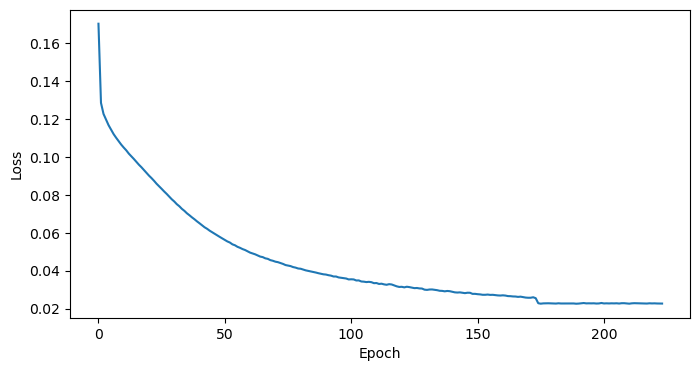

In [59]:
# plot learning curve
plt.figure(figsize=(8, 4))
plt.plot(epoch_losses[1:])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [51]:
model = CLM_LSTM(
    vocab_size=len(abstracts_vocab)
).to(device)

model_save_path = "/kaggle/working/model_225.pt"
model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

# 5. Generating Examples

In [73]:
print("Original Abstract:")
print(" ".join((tokenized_abstracts[10][:50])))
print('\n')
print("Generated Example:")
print(generate_text(model, "determination of", idx2word, word2idx, device, temperature=1.0))

Original Abstract:
determination of the ratio associated with the use of novel disease in older with polypharmacy is mandatory . our objective was to develop and validate a strategy to assess risk for adverse drug ( ade ) associated with ( ) and chloroquine ( ) , alone or in combination with


Generated Example:
determination of measure artery cardiovascular via june identical pox measure nasal personnel an free soluble ratio was . a quarantine , combination resonance artery mode part repetition scale part


In [76]:
print("Original Abstract:")
print(" ".join((tokenized_abstracts[30][:50])))
print('\n')
print("Generated Example:")
print(generate_text(model, "the new", idx2word, word2idx, device, temperature=1.0))

Original Abstract:
the new world virus ( ) is the causative agent of argentine hemorrhagic fever , a lethal human infectious disease . adult laboratory mice are generally resistant to peripheral infection by . the mechanism underlying the mouse resistance to infection is largely unknown . we have that receptor knockout mice


Generated Example:
the new outcome measure contamination rate before what june expert via injection before economic formula beyond to pneumonia , because a major health within an insect virus ( )


In [90]:
print("Original Abstract:")
print(" ".join((tokenized_abstracts[130][:50])))
print('\n')
print("Generated Example:")
print(generate_text(model, "the effects", idx2word, word2idx, device, temperature=1.0))

Original Abstract:
the effects of a novel adjuvant composed of a , cholesterol , dimethyl ammonium bromide , and ( ) on protective immunity against avian coccidiosis following immunization with an protein were determined . broiler were subcutaneously with isotonic saline ( control ) , alone , or with at and days


Generated Example:
the effects score chromatography measure shedding ( and plus , inability land stress dimer growth plus ; validation independently within large lung ( p < distance visceral ) .


In [93]:
print("Original Abstract:")
print(" ".join((tokenized_abstracts[140][:50])))
print('\n')
print("Generated Example:")
print(generate_text(model, "the identification", idx2word, word2idx, device, temperature=1.0))

Original Abstract:
the identification of to severe in young remains partially . low birth weight ( ) cardiovascular and lung development and to adult disease . we that is a risk factor for severe in . we a prospective cohort of ( ) with infection in a tertiary hospital , where %


Generated Example:
the identification participation behaviour following empiric theory , stress atrophy initially insufficient mode distance equipment concentration their vertebrate to the process of pervasive ( ) ( ) to activity


In [95]:
print("Original Abstract:")
print(" ".join((tokenized_abstracts[150][:50])))
print('\n')
print("Generated Example:")
print(generate_text(model, "severe acute", idx2word, word2idx, device, temperature=1.0))

Original Abstract:
severe acute respiratory syndrome ( ) is a recently febrile respiratory illness that first in southern china in , since spread to several , and in more than and more than . the disease been etiologically linked to a novel that been the . it to be spread primarily by


Generated Example:
severe acute and necrosis within abdomen hypertension persisting . notably vitamin e effective serum ( , , ) , and pa , , and , but also age and


As we can see, the generated sentences do not entirely make sense. There is much to improve on both the semantic and synactic aspect of the generation. This could possibly be improved by using a more complex architechture and a better set of corpus.